# **1. 준비된 Custom Dataset 가져오기**

**1-1. 데이터 가져오기**
- VM에 dataset.zip 파일로 업로드 후 압축 풀기

In [ ]:
import zipfile

with zipfile.ZipFile('/content/parking_data.zip') as target_file:
    target_file.extractall('/content/parking_data')

In [ ]:
!pip install labelme2yolo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.2 MB/s eta 0:00:00


In [ ]:
!labelme2yolo --json_dir /content/parking_data --val_size 0.2 --output_format polygon  # --output_format bbox 또는 polygon(default는 bbox)

[2024-10-03T12:54:17Z INFO  labelme2yolo] Starting the conversion process...
[2024-10-03T12:54:17Z INFO  labelme2yolo] Read and parsed 250 JSON files.
⠁ [Train] [00:00:00] [##########>-----------------------------] 50/200 (1s)
⠙ [Train] [00:00:00] [##############################>---------] 150/200 (0s)
  [Train] [00:00:00] [########################################] 200/200 (0s)
⠁ [Val] [00:00:00] [########################################] 50/50 (0s)
  [Val] [00:00:00] [########################################] 50/50 (0s)
[2024-10-03T12:54:18Z INFO  labelme2yolo] Creating dataset.yaml file...
[2024-10-03T12:54:18Z INFO  labelme2yolo] Conversion process completed successfully.


**1-2. yaml파일 확인하기**
- yaml 파일은 모델학습에 사용되는 데이터의 위치, 클래스의 수, 클래스명의 정보를 가지고 있다.

In [ ]:
!cat /content/parking_data/YOLODataset/dataset.yaml

path: /content/parking_data/YOLODataset
train: images/train
val: images/val
test:

names:
    0: Driveable Space
    1: Parking Space


# **2. Custom yaml 파일을 만들자.**

In [ ]:
# PyYAML을 설치하자
!pip install PyYAML

In [ ]:
import yaml

data_cf = {'train' : '/content/parking_data/YOLODataset/images/train',
           'val' : '/content/parking_data/YOLODataset/images/val',
           'names' : ["Driveable Space", "Parking Space"],
           'nc' : 2 }

# parking_data.yaml 이란 이름으로 custom yaml 파일을 만든다.
with open('/content/parking_data/YOLODataset/parking_data.yaml', 'w') as f:
  yaml.dump(data_cf, f)

# parking_data.yaml 확인
with open('/content/parking_data/YOLODataset/parking_data.yaml', 'r') as f:
  parking_yaml = yaml.safe_load(f)
  display(parking_yaml)

{'names': ['Driveable Space', 'Parking Space'],
 'nc': 2,
 'train': '/content/parking_data/YOLODataset/images/train',
 'val': '/content/parking_data/YOLODataset/images/val'}

# **3. YOLO11을 사용하기 위한 Setup(셋업)**

In [ ]:
# ultralytics 설치
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.7/881.7 kB 23.3 MB/s eta 0:00:00


In [ ]:
# ultralytics 를 불러오고 체크
import ultralytics
ultralytics.checks()

Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.5/112.6 GB disk)


# **4. Custom YOLO Training(학습)**

**Segmentation 모델로 사용할 수 있는 모델의 종류**

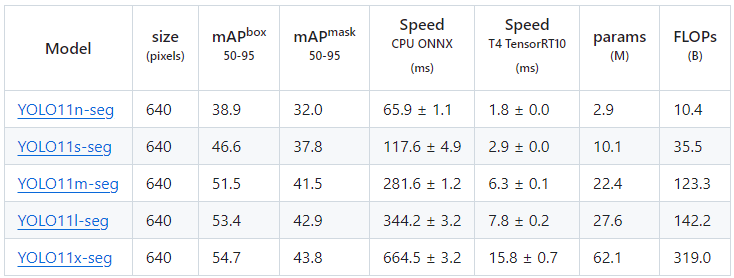

In [ ]:
# ultralytics에서 YOLO 모듈을 불러옴
from ultralytics import YOLO
# yolo11n-seg.pt 모델의 아키텍처와 가중치을 함께 불러옴
model = YOLO('yolo11n-seg.pt')

100%|██████████| 5.90M/5.90M [00:00<00:00, 121MB/s]


In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

**불러온 모델 아키텍처를 이용하여 우리가 준비한 Custom Dataset으로 학습을 시켜보자.**

In [ ]:
model.train(data='/content/parking_data/YOLODataset/parking_data.yaml', epochs=100, patience=10, batch=8, imgsz=640)

Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/parking_data/YOLODataset/parking_data.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 82.2MB/s]


AMP: checks passed ✅


train: Scanning /content/parking_data/YOLODataset/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1790.15it/s]

train: New cache created: /content/parking_data/YOLODataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/parking_data/YOLODataset/labels/val... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 1007.97it/s]

val: New cache created: /content/parking_data/YOLODataset/labels/val.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.59G      1.355      3.271       2.99       1.37         33        640: 100%|██████████| 25/25 [00:13<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all         50         57    0.00602      0.643      0.358      0.187    0.00602      0.643      0.346       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.57G     0.8292      1.495      1.731      1.068         30        640: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all         50         57    0.00451      0.643      0.491      0.312    0.00446      0.571      0.491        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.59G      0.857       1.33      1.272      1.059         23        640: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all         50         57      0.968        0.5      0.492      0.408      0.959       0.49       0.49      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.57G     0.8117      1.283      1.155       1.07         27        640: 100%|██████████| 25/25 [00:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         50         57      0.996        0.5      0.498      0.335      0.996        0.5      0.497        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.57G      0.836      1.344      1.084      1.054         36        640: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all         50         57      0.988        0.5      0.498      0.398      0.978       0.49      0.495      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.57G     0.7081      1.126     0.9623     0.9845         30        640: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all         50         57       0.99      0.493       0.57      0.322      0.985       0.47      0.565      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.59G     0.7777      1.193      0.975     0.9963         25        640: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all         50         57      0.895      0.571      0.575      0.478      0.895      0.571      0.577      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.57G     0.7732      1.095      0.918      1.025         24        640: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all         50         57      0.769      0.643      0.619      0.447      0.769      0.643      0.619      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.59G     0.7393      1.051     0.8688     0.9965         25        640: 100%|██████████| 25/25 [00:06<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


                   all         50         57      0.644      0.571       0.56      0.426      0.644      0.571       0.56      0.435

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.59G     0.7207      1.056     0.8322     0.9935         27        640: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

                   all         50         57      0.947      0.561      0.585      0.481      0.947      0.561      0.599      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.57G     0.6678      1.005     0.7803      1.002         26        640: 100%|██████████| 25/25 [00:08<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all         50         57      0.945      0.642      0.664      0.475      0.945      0.642      0.647      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.57G     0.6786      1.047     0.7561     0.9956         30        640: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all         50         57       0.56      0.643      0.622      0.501       0.56      0.643      0.615      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.55G     0.6368     0.9958     0.7317     0.9744         27        640: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


                   all         50         57      0.932      0.643      0.662      0.514       0.93      0.643      0.661      0.542

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.57G     0.6382     0.9731     0.7042     0.9654         22        640: 100%|██████████| 25/25 [00:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all         50         57      0.738      0.624      0.648       0.52      0.738      0.624      0.648      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.55G     0.6752     0.9647     0.7076     0.9729         25        640: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all         50         57      0.982      0.639       0.64      0.503      0.982      0.639       0.65      0.499

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.57G     0.6735     0.9393      0.698     0.9853         22        640: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


                   all         50         57      0.895       0.64      0.715      0.401      0.906       0.63       0.64      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.57G     0.6335     0.8952     0.6771     0.9742         31        640: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all         50         57      0.993      0.633      0.679      0.563      0.993      0.633      0.659      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.55G     0.6231     0.7982     0.6588     0.9715         28        640: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all         50         57      0.942      0.618      0.654      0.554      0.942      0.618      0.659      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.57G     0.6073     0.8887     0.6445     0.9473         20        640: 100%|██████████| 25/25 [00:06<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

                   all         50         57      0.911      0.633      0.678      0.444      0.913      0.633      0.693      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.57G     0.6294     0.8969     0.6457     0.9779         26        640: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all         50         57      0.904      0.633      0.668      0.461      0.904      0.633      0.665      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.55G     0.6049     0.8254     0.5949     0.9553         24        640: 100%|██████████| 25/25 [00:06<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all         50         57      0.943      0.638      0.664      0.492      0.943      0.638      0.668      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.57G     0.5764     0.9012     0.5781     0.9529         23        640: 100%|██████████| 25/25 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all         50         57      0.765      0.643      0.709      0.583      0.765      0.643      0.721       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.57G     0.5758     0.8848     0.5688     0.9389         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


                   all         50         57       0.96      0.704      0.753      0.609      0.951      0.694      0.755      0.529

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.57G     0.6047     0.8942     0.5679     0.9641         26        640: 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all         50         57      0.987      0.635       0.72      0.588      0.987      0.635      0.734      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.55G     0.5458     0.8059     0.5302     0.9386         27        640: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


                   all         50         57      0.938      0.643      0.649      0.553      0.938      0.643      0.657      0.565

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.59G     0.5628     0.7498       0.53     0.9602         26        640: 100%|██████████| 25/25 [00:07<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all         50         57      0.942      0.639       0.66      0.542      0.942      0.639      0.657       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.57G      0.585     0.7687     0.5399     0.9406         26        640: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all         50         57      0.709      0.786      0.753      0.573      0.828      0.643      0.713      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.57G     0.5598      0.766     0.5254     0.9571         26        640: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


                   all         50         57       0.82      0.786      0.788       0.58      0.739      0.714      0.728      0.567

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.57G     0.5498     0.8163     0.5061     0.9415         24        640: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all         50         57      0.971      0.786      0.883      0.635      0.998      0.711      0.773        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.57G      0.543     0.7799     0.4981     0.9318         29        640: 100%|██████████| 25/25 [00:08<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all         50         57      0.991      0.914      0.938      0.619      0.866      0.786      0.824      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.57G     0.5155     0.7608     0.4808     0.9334         22        640: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

                   all         50         57      0.986      0.781      0.819      0.606      0.979      0.712       0.74       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.57G      0.545     0.7542     0.4954      0.954         26        640: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         50         57      0.804      0.779      0.793      0.565      0.839      0.704       0.73      0.571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.57G     0.5121     0.7089     0.4665     0.9366         26        640: 100%|██████████| 25/25 [00:07<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


                   all         50         57       0.73      0.714      0.693       0.52      0.948      0.786      0.806       0.54

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.57G     0.5158      0.756     0.4789     0.9246         26        640: 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all         50         57      0.787      0.738       0.79      0.561      0.787      0.738      0.765      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.57G     0.5188     0.7652     0.4693      0.918         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


                   all         50         57      0.939      0.643      0.698      0.588      0.939      0.643      0.694      0.557

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.57G     0.5085     0.7165     0.4539     0.9345         26        640: 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

                   all         50         57      0.753      0.714      0.754      0.589      0.753      0.714      0.744      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.57G     0.5173     0.7182     0.4598     0.9461         20        640: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all         50         57      0.773      0.899      0.851      0.621      0.837      0.786      0.847      0.586



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.57G     0.5187     0.6945      0.448     0.9247         25        640: 100%|██████████| 25/25 [00:06<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all         50         57      0.755      0.786      0.751        0.6      0.727      0.714      0.732      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.57G     0.5515     0.6848     0.4741     0.9359         32        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all         50         57      0.658      0.825      0.759      0.613      0.944      0.637       0.71      0.599
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 29, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



39 epochs completed in 0.127 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.4 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


                   all         50         57      0.971      0.786      0.883      0.637      0.998      0.711      0.774      0.601
       Driveable Space         50         50      0.993          1      0.995      0.886      0.996          1      0.995      0.879
         Parking Space          6          7      0.949      0.571       0.77      0.387          1      0.422      0.554      0.322
Speed: 0.5ms preprocess, 7.9ms inference, 0.1ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b1873eca950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

# **5. Training(학습) 결과 확인**

**학습 결과를 그래프로 저장한 파일을 통해 확인해 본다**

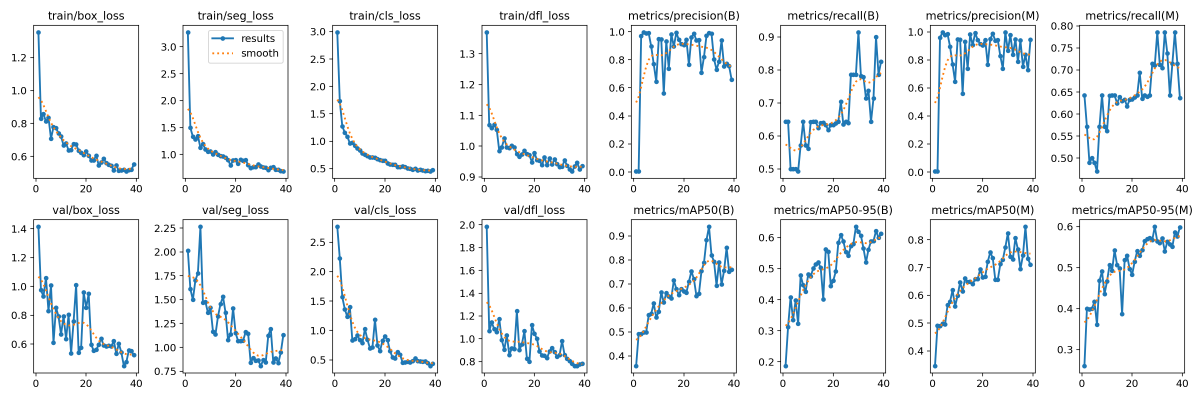

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

result_img = cv2.imread('/content/runs/segment/train/results.png')
fix_width = 1200
height,width = result_img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
result_img = cv2.resize(result_img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(result_img)

**Custom 모델이 분류할 수 있는 부류 확인**

In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 2
{0: 'Driveable Space', 1: 'Parking Space'}


# **6. Custom 모델로 Segmentation(분할)**

**Image Segmentation**

In [ ]:
# 모델 예측
results = model.predict(source='/content/parking_data/YOLODataset/images/val/00000283.jpg', save=True)


image 1/1 /content/parking_data/YOLODataset/images/val/00000283.jpg: 384x640 1 Driveable Space, 109.9ms
Speed: 2.3ms preprocess, 109.9ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/train2


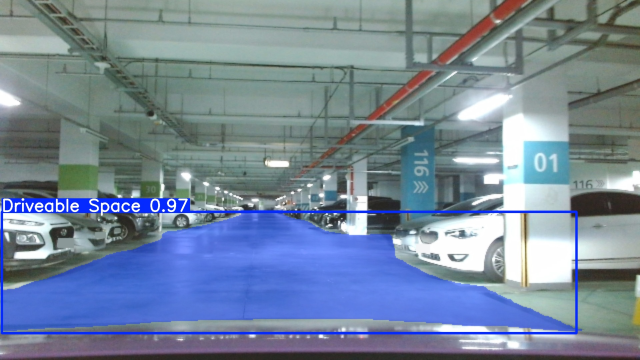

In [ ]:
# 예측 이미지 확인
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/runs/segment/train2/00000283.jpg')
fix_width = 640
height,width = img.shape[:2]
ratio = fix_width / width
demension = (fix_width, int(height*ratio))
img = cv2.resize(img, demension, interpolation=cv2.INTER_AREA)
cv2_imshow(img)

# **7. 학습된 모델을 불러와 검출**

**Image를 Segmentation하여 동영상으로 저장**

In [ ]:
# ultralytics 설치
!pip install ultralytics

# ultralytics 를 불러오고 체크
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.195 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/78.2 GB disk)


In [ ]:
# ultralytics에서 YOLO 모듈을 불러옴
from ultralytics import YOLO
# 학습된 모델의 아키텍처와 가중치을 함께 불러옴
model = YOLO('/content/runs/segment/train/weights/best.pt')

In [ ]:
# 모델이 분류할 수 있는 부류의 수 확인
print(type(model.names), len(model.names))
# 모델이 분류할 수 있는 부류 확인
print(model.names)

<class 'dict'> 2
{0: 'Driveable Space', 1: 'Parking Space'}


In [ ]:
import os
import cv2
from ultralytics import YOLO
from tqdm import tqdm

model = YOLO('/content/runs/segment/train/weights/best.pt')

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('output.mp4', fourcc, 10, (1920, 1080))

real_test_dir = '/content/parking_data/YOLODataset/images/val'
image_paths = []

for filename in sorted(os.listdir(real_test_dir)):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in tqdm(image_paths):
    img = cv2.imread(image_path)

    results = model.predict(img, save=True)

    annotated_img = results[0].plot(conf=False, boxes=False)

    out.write(annotated_img)

out.release()

  0%|          | 0/50 [00:00<?, ?it/s]


0: 384x640 1 Driveable Space, 18.1ms
Speed: 3.0ms preprocess, 18.1ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


  2%|▏         | 1/50 [00:00<00:14,  3.49it/s]


0: 384x640 1 Driveable Space, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


  4%|▍         | 2/50 [00:00<00:08,  5.65it/s]


0: 384x640 1 Driveable Space, 12.6ms
Speed: 4.1ms preprocess, 12.6ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


  6%|▌         | 3/50 [00:00<00:06,  6.74it/s]


0: 384x640 1 Driveable Space, 15.2ms
Speed: 3.9ms preprocess, 15.2ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


  8%|▊         | 4/50 [00:00<00:06,  7.48it/s]


0: 384x640 1 Driveable Space, 1 Parking Space, 12.6ms
Speed: 3.4ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 1 Parking Space, 13.0ms
Speed: 4.1ms preprocess, 13.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 12%|█▏        | 6/50 [00:00<00:05,  8.76it/s]


0: 384x640 1 Driveable Space, 12.8ms
Speed: 3.4ms preprocess, 12.8ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 20.9ms
Speed: 3.3ms preprocess, 20.9ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 16%|█▌        | 8/50 [00:01<00:04,  9.24it/s]


0: 384x640 1 Driveable Space, 13.4ms
Speed: 2.7ms preprocess, 13.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 12.5ms
Speed: 3.9ms preprocess, 12.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 20%|██        | 10/50 [00:01<00:04,  9.67it/s]


0: 384x640 1 Driveable Space, 15.8ms
Speed: 3.7ms preprocess, 15.8ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 12.8ms
Speed: 3.7ms preprocess, 12.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 24%|██▍       | 12/50 [00:01<00:03,  9.82it/s]


0: 384x640 1 Driveable Space, 12.5ms
Speed: 3.7ms preprocess, 12.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 16.2ms
Speed: 3.5ms preprocess, 16.2ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 28%|██▊       | 14/50 [00:01<00:03,  9.91it/s]


0: 384x640 1 Driveable Space, 15.3ms
Speed: 3.1ms preprocess, 15.3ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 30%|███       | 15/50 [00:01<00:03,  9.72it/s]


0: 384x640 1 Driveable Space, 15.6ms
Speed: 2.9ms preprocess, 15.6ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 32%|███▏      | 16/50 [00:01<00:03,  9.75it/s]


0: 384x640 1 Driveable Space, 12.4ms
Speed: 3.5ms preprocess, 12.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 13.0ms
Speed: 2.9ms preprocess, 13.0ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 36%|███▌      | 18/50 [00:02<00:03,  9.84it/s]


0: 384x640 1 Driveable Space, 12.4ms
Speed: 3.3ms preprocess, 12.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 40%|████      | 20/50 [00:02<00:02, 10.14it/s]


0: 384x640 1 Driveable Space, 12.6ms
Speed: 3.2ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 44%|████▍     | 22/50 [00:02<00:02, 10.27it/s]


0: 384x640 1 Driveable Space, 2 Parking Spaces, 12.8ms
Speed: 4.2ms preprocess, 12.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 1 Parking Space, 17.5ms
Speed: 3.2ms preprocess, 17.5ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 48%|████▊     | 24/50 [00:02<00:02,  9.95it/s]


0: 384x640 1 Driveable Space, 14.8ms
Speed: 3.2ms preprocess, 14.8ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 50%|█████     | 25/50 [00:02<00:02,  9.93it/s]


0: 384x640 1 Driveable Space, 12.7ms
Speed: 3.7ms preprocess, 12.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 12.5ms
Speed: 3.2ms preprocess, 12.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 54%|█████▍    | 27/50 [00:02<00:02,  9.99it/s]


0: 384x640 1 Driveable Space, 12.5ms
Speed: 3.7ms preprocess, 12.5ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 56%|█████▌    | 28/50 [00:02<00:02,  9.98it/s]


0: 384x640 1 Driveable Space, 12.7ms
Speed: 3.5ms preprocess, 12.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 12.6ms
Speed: 3.6ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 60%|██████    | 30/50 [00:03<00:01, 10.20it/s]


0: 384x640 1 Driveable Space, 12.5ms
Speed: 3.3ms preprocess, 12.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 12.9ms
Speed: 3.6ms preprocess, 12.9ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 64%|██████▍   | 32/50 [00:03<00:01, 10.31it/s]


0: 384x640 1 Driveable Space, 13.1ms
Speed: 3.7ms preprocess, 13.1ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 15.9ms
Speed: 4.8ms preprocess, 15.9ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 68%|██████▊   | 34/50 [00:03<00:01, 10.04it/s]


0: 384x640 1 Driveable Space, 15.1ms
Speed: 3.1ms preprocess, 15.1ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict

0: 384x640 1 Driveable Space, 40.4ms
Speed: 3.3ms preprocess, 40.4ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 72%|███████▏  | 36/50 [00:03<00:01,  9.04it/s]


0: 384x640 1 Driveable Space, 17.3ms
Speed: 3.0ms preprocess, 17.3ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 74%|███████▍  | 37/50 [00:03<00:01,  8.98it/s]


0: 384x640 1 Driveable Space, 20.5ms
Speed: 3.2ms preprocess, 20.5ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 76%|███████▌  | 38/50 [00:04<00:01,  8.65it/s]


0: 384x640 1 Driveable Space, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 78%|███████▊  | 39/50 [00:04<00:01,  8.45it/s]


0: 384x640 1 Driveable Space, 2 Parking Spaces, 16.3ms
Speed: 3.3ms preprocess, 16.3ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 80%|████████  | 40/50 [00:04<00:01,  8.06it/s]


0: 384x640 1 Driveable Space, 14.6ms
Speed: 3.1ms preprocess, 14.6ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 82%|████████▏ | 41/50 [00:04<00:01,  7.96it/s]


0: 384x640 1 Driveable Space, 18.5ms
Speed: 3.2ms preprocess, 18.5ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 84%|████████▍ | 42/50 [00:04<00:01,  7.55it/s]


0: 384x640 1 Driveable Space, 17.1ms
Speed: 3.1ms preprocess, 17.1ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 86%|████████▌ | 43/50 [00:04<00:00,  7.60it/s]


0: 384x640 2 Driveable Spaces, 17.2ms
Speed: 3.3ms preprocess, 17.2ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 88%|████████▊ | 44/50 [00:04<00:00,  7.44it/s]


0: 384x640 1 Driveable Space, 14.4ms
Speed: 3.8ms preprocess, 14.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 90%|█████████ | 45/50 [00:05<00:00,  7.17it/s]


0: 384x640 1 Driveable Space, 14.5ms
Speed: 3.7ms preprocess, 14.5ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 92%|█████████▏| 46/50 [00:05<00:00,  7.28it/s]


0: 384x640 1 Driveable Space, 20.7ms
Speed: 3.2ms preprocess, 20.7ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 94%|█████████▍| 47/50 [00:05<00:00,  7.21it/s]


0: 384x640 1 Driveable Space, 21.3ms
Speed: 3.4ms preprocess, 21.3ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 96%|█████████▌| 48/50 [00:05<00:00,  7.18it/s]


0: 384x640 1 Driveable Space, 2 Parking Spaces, 18.1ms
Speed: 3.4ms preprocess, 18.1ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


 98%|█████████▊| 49/50 [00:05<00:00,  7.34it/s]


0: 384x640 1 Driveable Space, 3 Parking Spaces, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict


100%|██████████| 50/50 [00:05<00:00,  8.70it/s]
